In [1]:
import os
import numpy as np
from keras.datasets.mnist import load_data
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import Flatten
from keras.layers import Reshape
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model
from numpy import expand_dims
from numpy import ones
from numpy import zeros
from numpy.random import randn
from numpy.random import rand
from numpy.random import randint

In [2]:
#Exploring ways to better organise data
DATA_FOLDER = "../data/real_faces/"
train_folder = "train_sample_videos"
test_folder = "test_videos"

print(f"Real Faces for Training: {len(os.listdir(os.path.join(DATA_FOLDER)))}")

Real Faces for Training: 9780


In [3]:
#Defining the standalone descriminator model

#The model must take a sample image from our dataset as input and output a classification prediction as to whether the sample
#is real or fake.

#The discriminator model has two convolutional layers with 64 filters each, a small kernel size of 3, 
# and larger than normal stride of 2. The model has no pooling layers and a single node in the output layer 
# with the sigmoid activation function to predict whether the input sample is real or fake.
#  The model is trained to minimize the binary cross entropy loss function, appropriate for binary classification.

#We will use some of the best practices when it comes to defining a discriminator model such as using LeakyReLU, using dropout,
# and using the Adam version of the gradient descent with a learning rate of 0.0002 and a momentum of 0.5

def define_discriminator(input_shape = (28,28,1)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides = (2,2), padding = "same", input_shape = input_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
	# compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    return model

Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0         
                                        

2022-03-27 22:49:59.973222: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-27 22:49:59.973352: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/leo/miniforge3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


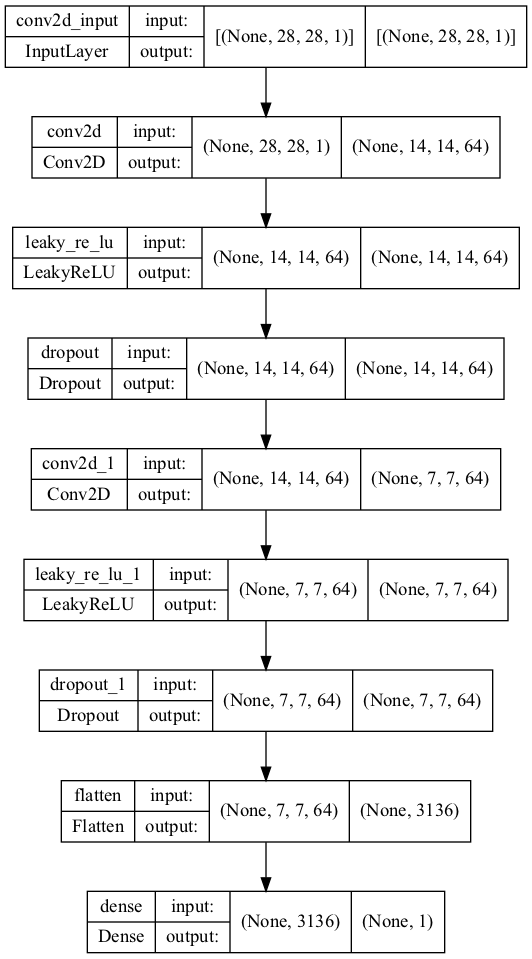

In [4]:
#calling the function to define the model
model = define_discriminator()

#summarizing the model
model.summary()

#plotting the model
plot_model(model, to_file = "discriminator_plot.png", show_shapes = True, show_layer_names = True)

In [5]:
#We need a way to convert our training set into the correct format

def load_real_samples(image_path):
    from keras.preprocessing.image import load_img
    from keras.preprocessing.image import img_to_array
    from keras.preprocessing.image import array_to_img
    
    #Defining master array
    master_list = list()

    for image in os.listdir(image_path):
        #loading image
        img = load_img(os.path.join(image_path,image))

        # convert to numpy array
        img_array = img_to_array(img)
        #Standardizing to float
        img_array = img_array.astype("float32")
        #Grtting value between 0 and 1
        img_array/=255.0

        master_list.append(img_array)

    return np.array(master_list).shape

In [6]:
training_data = load_real_samples("/Users/leo/Desktop/nova/deep_learning/deepfakedetector/data/real_faces")

/Users/leo/Desktop/nova/deep_learning/deepfakedetector/data/real_faces/9_1_2_20161219204347420.jpg.chip.jpg
/Users/leo/Desktop/nova/deep_learning/deepfakedetector/data/real_faces/1_1_2_20161219154612988.jpg.chip.jpg
/Users/leo/Desktop/nova/deep_learning/deepfakedetector/data/real_faces/16_0_0_20170104003740977.jpg.chip.jpg
/Users/leo/Desktop/nova/deep_learning/deepfakedetector/data/real_faces/1_1_3_20161219230734016.jpg.chip.jpg
/Users/leo/Desktop/nova/deep_learning/deepfakedetector/data/real_faces/26_1_1_20170103181931657.jpg.chip.jpg
/Users/leo/Desktop/nova/deep_learning/deepfakedetector/data/real_faces/2_0_2_20161219141650121.jpg.chip.jpg
/Users/leo/Desktop/nova/deep_learning/deepfakedetector/data/real_faces/53_1_0_20170110143534851.jpg.chip.jpg
/Users/leo/Desktop/nova/deep_learning/deepfakedetector/data/real_faces/36_1_4_20170104172843788.jpg.chip.jpg
/Users/leo/Desktop/nova/deep_learning/deepfakedetector/data/real_faces/37_0_0_20170104205628245.jpg.chip.jpg
/Users/leo/Desktop/nova

In [7]:
#When we are training the model we need to provide it with both real and generated characters
#So we need to define a function to provide it with a random subset of real images

def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

In [8]:
# generate n fake samples with class labels as for the time being we don't have a generator model
def generate_fake_samples(n_samples):
	# generate uniform random numbers in [0,1]
	X = rand(28 * 28 * n_samples)
	# reshape into a batch of grayscale images
	X = X.reshape((n_samples, 200, 200, 3))
	# generate 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

In [9]:
#We will ignore the idea of epochs for now (e.g. complete passes through the training dataset) and 
# fit the discriminator model for a fixed number of batches. The model will learn to discriminate between 
# real and fake (randomly generated) images rapidly, therefore, not many batches will be required before it learns 
# to discriminate perfectly.

#The train_discriminator() function implements this, using a batch size of 256 images where 128 are real 
# and 128 are fake each iteration.

#We update the discriminator separately for real and fake examples so that we can calculate the accuracy of the 
# model on each sample prior to the update. This gives insight into how the discriminator model is performing over time.

# train the discriminator model
def train_discriminator(model, dataset, n_iter=100, n_batch=256):
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_iter):
		# get randomly selected 'real' samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		# update discriminator on real samples
		_, real_acc = model.train_on_batch(X_real, y_real)
		# generate 'fake' examples
		X_fake, y_fake = generate_fake_samples(half_batch)
		# update discriminator on fake samples
		_, fake_acc = model.train_on_batch(X_fake, y_fake)
		# summarize performance
		print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

In [10]:
# define the discriminator model
model = define_discriminator()
# load image data
dataset = load_real_samples("/Users/leo/Desktop/nova/deep_learning/deepfakedetector/data/real_faces/")
# fit the model
train_discriminator(model, dataset)

/Users/leo/Desktop/nova/deep_learning/deepfakedetector/data/real_faces/9_1_2_20161219204347420.jpg.chip.jpg
/Users/leo/Desktop/nova/deep_learning/deepfakedetector/data/real_faces/1_1_2_20161219154612988.jpg.chip.jpg
/Users/leo/Desktop/nova/deep_learning/deepfakedetector/data/real_faces/16_0_0_20170104003740977.jpg.chip.jpg
/Users/leo/Desktop/nova/deep_learning/deepfakedetector/data/real_faces/1_1_3_20161219230734016.jpg.chip.jpg
/Users/leo/Desktop/nova/deep_learning/deepfakedetector/data/real_faces/26_1_1_20170103181931657.jpg.chip.jpg
/Users/leo/Desktop/nova/deep_learning/deepfakedetector/data/real_faces/2_0_2_20161219141650121.jpg.chip.jpg
/Users/leo/Desktop/nova/deep_learning/deepfakedetector/data/real_faces/53_1_0_20170110143534851.jpg.chip.jpg
/Users/leo/Desktop/nova/deep_learning/deepfakedetector/data/real_faces/36_1_4_20170104172843788.jpg.chip.jpg
/Users/leo/Desktop/nova/deep_learning/deepfakedetector/data/real_faces/37_0_0_20170104205628245.jpg.chip.jpg
/Users/leo/Desktop/nova